# ライブラリ

In [18]:
import sys
sys.path.append('../')
from setting import *

# 入出力

In [332]:
file_pred = data_path/'tmp/202012061919_all.csv'

# 読み込み

In [329]:
df_info = pd.read_csv(
    FILE_INFO_INTER,
    usecols=['condition_int', 'whether_int', 'race_id']
).set_index('race_id')
print(df_info.shape)
df_info.head(2)

(27125, 2)


,condition_int,whether_int
race_id,,
201001020110,1,2
201001020111,1,2


In [330]:
df_result = pd.read_csv(FILE_RESULT_INTER, usecols=['race_id', '馬名', '単勝'])
print(df_result.shape)
df_result.head(2)

(387828, 3)


,馬名,単勝,race_id
0,マイネルギブソン,6.0,201001020110
1,クルビット,42.1,201001020110


In [333]:
df_pred = pd.read_csv(file_pred, engine='python', encoding='cp932')
df_pred = df_pred.merge(df_result, how='left', on=['race_id', '馬名'])
print(df_pred.shape)
df_pred.head(2)

(148567, 5)


,arrival,馬名,race_id,pred_prob,単勝
0,9,スリースペシャル,201201010101,0.060123,49.5
1,1,アウトシャイン,201201010101,0.416512,1.7


# 正解フラグ

In [127]:
df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')
accuracy_id = df_pred.query('(arrival==1) and (pred_rank==1)').race_id

In [128]:
pd.crosstab(df_pred.arrival, df_pred.pred_rank).style.background_gradient()

pred_rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
arrival,,,,,,,,,,,,,,,,,,
1,2612,1710,1316,1050,834,712,539,400,333,271,214,164,132,75,59,39,14,8
2,1833,1644,1350,1096,995,809,626,518,420,329,233,195,148,114,90,51,22,8
3,1378,1404,1283,1128,1039,874,782,609,456,397,340,268,192,145,96,61,26,7
4,1000,1096,1147,1090,1008,964,819,697,611,513,417,324,267,182,127,111,47,36
5,775,957,954,1030,1007,996,905,814,727,528,468,378,285,240,185,139,49,36
6,650,742,884,885,1034,999,944,885,737,658,556,418,341,285,215,137,51,44
7,516,657,722,840,884,871,969,1003,849,750,613,495,410,312,234,184,69,46
8,395,529,654,723,779,856,933,1015,904,783,729,542,471,338,279,202,84,61
9,353,422,536,603,660,765,836,897,1014,868,714,590,477,427,384,257,104,72


In [131]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'
df_ac = df_ac.merge(
    df_pred.query('arrival==1')[['race_id', '単勝']].drop_duplicates('race_id').set_index('race_id'),
    how='left',
    left_index=True,
    right_index=True
)

df_ac['acc_flg'] = 0
df_ac.loc[df_ac.index.isin(accuracy_id), 'acc_flg'] = 1
tmp = pd.pivot_table(
    df_pred.query('pred_rank <=2'),
    values='pred_prob',
    index='race_id',
    columns='pred_rank'
)
tmp.columns = ['score1', 'score2']
df_ac = df_ac.merge(tmp, how='left', left_index=True, right_index=True)
df_ac['s_diff'] = df_ac.score1 - df_ac.score2

df_ac = df_ac.merge(df_info, how='left', left_index=True, right_index=True)

df_ac['EV'] = df_ac.単勝 * df_ac.score1
df_ac['EV_diff'] = df_ac.EV * df_ac.s_diff
df_ac['s_diff_rate'] = df_ac.s_diff * df_ac.score1

In [132]:
df_ac.head()

,単勝,acc_flg,score1,score2,s_diff
race_id,,,,,
201201010101,1.7,0,0.450744,0.416512,0.034232
201201010104,3.7,1,0.504015,0.367944,0.136070
201201010108,4.9,0,0.570118,0.405596,0.164521
201201010110,65.5,0,0.454435,0.313319,0.141116
201201010112,28.5,0,0.480149,0.335301,0.144847


# 購入閾値検索

In [ ]:
def get_return(df, col, vmax=1, step=0.01, over=True, plot_min=0.8):
    df_ret = pd.DataFrame(columns=['対象数', '回収率'])
    if over:
        op = '>'
    else:
        op = '<'
    max_ret = -10000
    max_th = -1
    max_len = -1
    for th in np.arange(0, vmax, step):
        th = round(th, 2)
        tmp = df.query(col + op + str(th))
        ret = round((tmp.query('acc_flg==1').単勝.sum()/tmp.shape[0]), 3)
        if ret > max_ret:
            max_ret = ret
            max_th = th
            max_len = len(tmp)
        df_ret.loc[th] = [tmp.shape[0], ret]
    print(f'対象カラム: {col}, 最大回収率: {max_ret}, 閾値: {max_th}, 対象数: {max_len}, 対象率: {round(max_len/df.shape[0], 3)}')
    
    df_ret['対象率'] = df_ret.対象数 / df.shape[0]
    
#     plt.scatter(max_th, max_ret, s=100, c='none', edgecolors='blue')
    df_ret.回収率.plot()
    plt.plot([0,vmax], [1,1])
    plt.ylim(plot_min, )
    plt.ylabel('回収率')
    plt.xlabel(col)
    plt.twinx()
    df[col].hist(bins=20, alpha=.1, color='c', grid=False, range=(0, vmax))
    plt.ylabel('件数')
    plt.show()
    return df_ret, max_th

acc_flg
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: EV, dtype: object

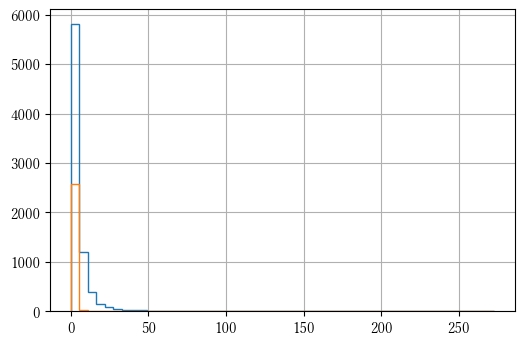

In [135]:
df_ac.groupby('acc_flg').EV.hist(bins=50, histtype='step', range=(0, df_ac.EV.max()))

acc_flg
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: s_diff_rate, dtype: object

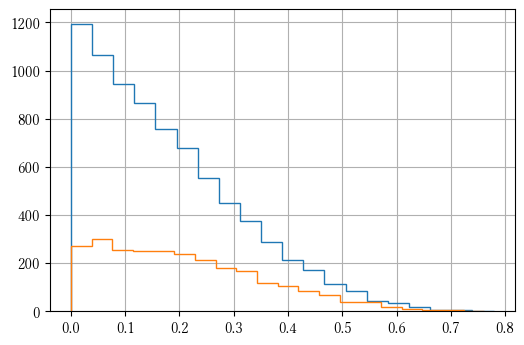

In [136]:
df_ac.groupby('acc_flg').s_diff_rate.hist(bins=20, histtype='step')

acc_flg
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: s_diff, dtype: object

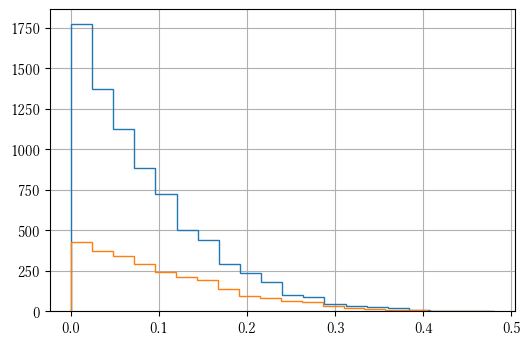

In [137]:
df_ac.groupby('acc_flg').s_diff.hist(bins=20, histtype='step')

acc_flg
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 単勝, dtype: object

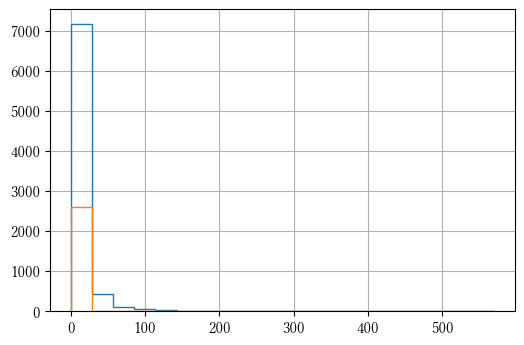

In [138]:
df_ac.groupby('acc_flg').単勝.hist(bins=20, histtype='step', range=(0, df_ac.単勝.max()))

対象カラム: EV, 最大回収率: 1.122, 閾値: 2, 対象数: 4806, 対象率: 0.459


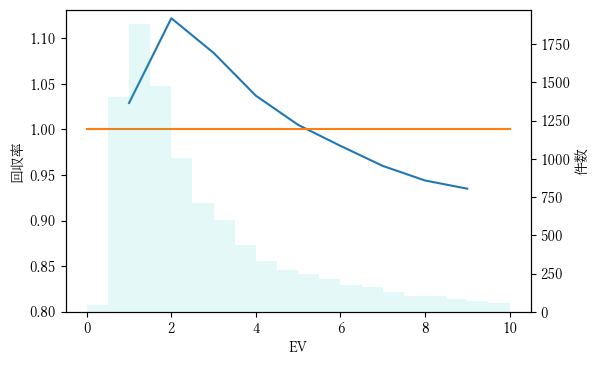

In [321]:
df_ret, max_th = get_return(df_ac, 'EV', 10, 1, over=False)

対象カラム: EV_diff, 最大回収率: 1.011, 閾値: 0.15, 対象数: 5213, 対象率: 0.498


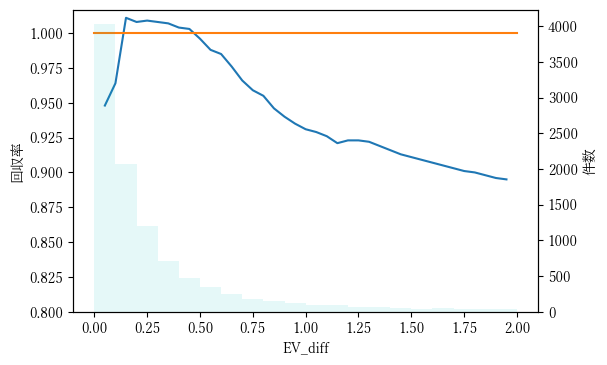

In [322]:
df_ret, max_th = get_return(df_ac, 'EV_diff', 2, 0.05, over=False)

対象カラム: 単勝, 最大回収率: 1.149, 閾値: 2.81, 対象数: 2489, 対象率: 0.238


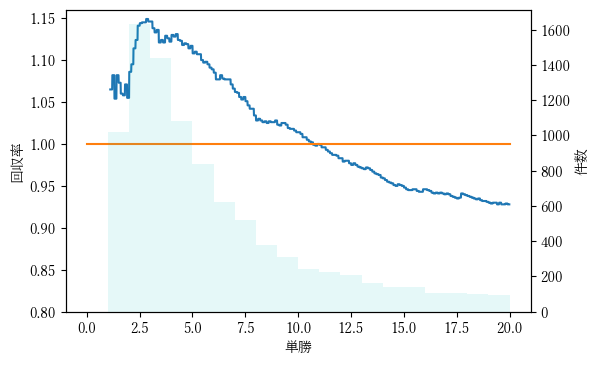

In [323]:
df_ret, max_th = get_return(df_ac, '単勝', 20, 0.01, over=False)

対象カラム: score1, 最大回収率: 1.45, 閾値: 0.72, 対象数: 2, 対象率: 0.0


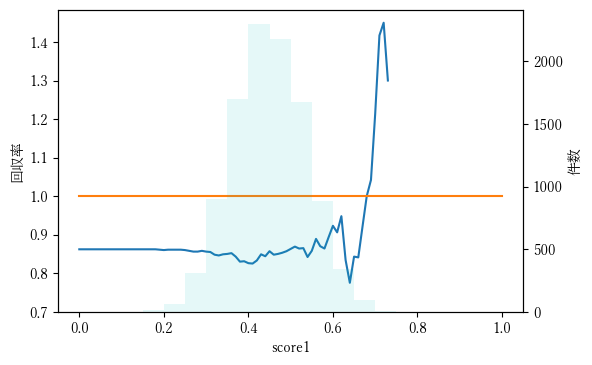

In [324]:
df_ret, max_th = get_return(df_ac, 'score1', 1, 0.01, over=True, plot_min=0.7)

対象カラム: s_diff, 最大回収率: 1.05, 閾値: 0.45, 対象数: 4, 対象率: 0.0


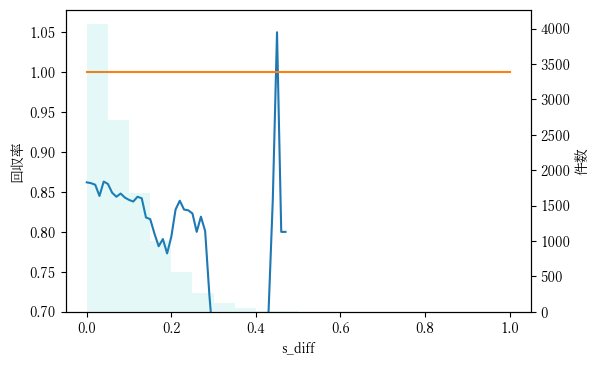

In [325]:
df_ret, max_th = get_return(df_ac, 's_diff', 1, 0.01, over=True, plot_min=0.7)

対象カラム: s_diff_rate, 最大回収率: 1.6, 閾値: 0.32, 対象数: 1, 対象率: 0.0


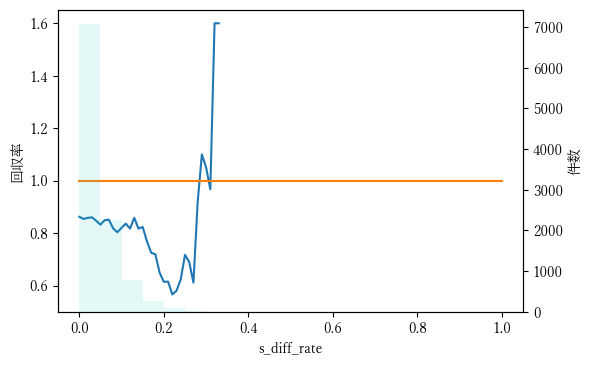

In [326]:
df_ret, max_th = get_return(df_ac, 's_diff_rate', 1, 0.01, over=True, plot_min=0.5)

# 購入モデル

## ライブラリ

In [146]:
import xgboost as xgb

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score

## 学習データ作成

In [ ]:
# one-hot
df_use = pd.get_dummies(df_ac, columns=['whether_int', 'condition_int'], drop_first=True).dropna()

# target
df_use['target'] = df_use.acc_flg.copy()

In [150]:
df_train, df_test = train_test_split(df_use)
print(df_train.shape)
print(df_test.shape)

(7851, 13)
(2618, 13)


In [151]:
# 不均衡データ調整
target_size = (df_train.target==1).sum()

df_train_0 = df_train[df_train.target==0]
df_train_use = df_train_0.sample(target_size, random_state=0)
df_train_use = pd.concat([df_train_use, df_train[df_train.target==1]])

# X_train_use = X_train.loc[y_train_use.index]

In [152]:
X_cols = [col for col in df_train.columns if col not in {'acc_flg', 'target'}]
print(len(X_cols))

11


In [153]:
X_train = df_train_use[X_cols]
X_test = df_test[X_cols]
y_train = df_train_use['target']
y_test = df_test['target']

# X_train = df_use[X_cols]
# y_train = df_use['target']
# X_test = df_use[X_cols]
# y_test = df_use['target']

In [154]:
tmp = y_train.to_frame()
tmp['種類'] = 'train'
tmp2 = y_test.to_frame()
tmp2['種類'] = 'test'
tmp3 = pd.concat([tmp, tmp2])
df_sampling = pd.crosstab(tmp3.種類, tmp3.target, margins=True)
df_sampling

target,0,1,All
種類,,,
test,1965,653,2618
train,1959,1959,3918
All,3924,2612,6536


In [1]:
s_rate = y_test.sum() / len(y_test)
# s_rate = (y_test==1).sum() / y_test.shape[0]
s_rate

NameError: name 'y_test' is not defined

## 学習

In [167]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [168]:
pd.Series(clf.coef_[0], X_train.columns).to_frame()

,0
単勝,0.066113
score1,3.846486
score2,-0.200839
s_diff,4.047325
EV,-0.680756
EV_diff,-2.101846
s_diff_rate,2.254235
whether_int_2,0.000751
whether_int_3,0.420818
condition_int_2,0.059311


## 予測

In [169]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

In [172]:
prob2 = y_pred_prob / (y_pred_prob + (1 - y_pred_prob) / s_rate)

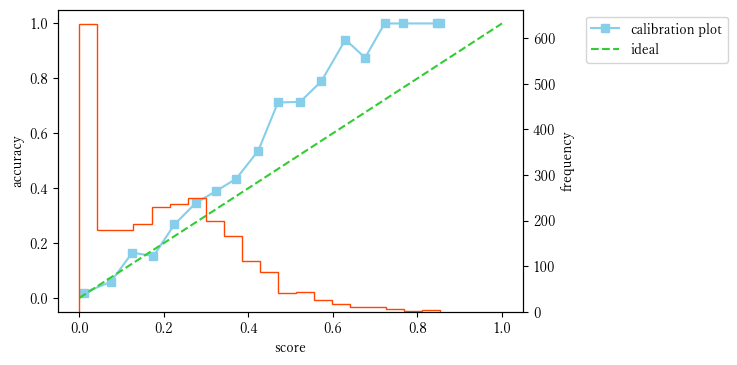

In [173]:
prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob2, n_bins=20)

fig, ax1 = plt.subplots()
ax1.plot(prob_pred, prob_true, marker='s', label='calibration plot', color='skyblue')
ax1.plot([0, 1], [0, 1], linestyle='--', label='ideal', color='limegreen')
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
ax2 = ax1.twinx()
ax2.hist(prob2, bins=20, histtype='step', color='orangered')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('score')
ax2.set_ylabel('frequency')
# fig.savefig(log_path/'image/calibration_plot.png', bbox_inches='tight', pad_inche=.05)
plt.show()

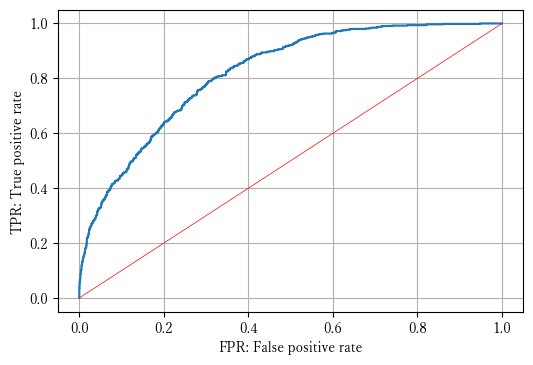

In [174]:
fpr_all, tpr_all, thresholds_all = roc_curve(y_test, y_pred_prob, drop_intermediate=False)
fig, ax = plt.subplots()
ax.plot(fpr_all, tpr_all, marker='o', markersize=.01)
ax.plot([0,1],[0,1], color='red', linewidth=.5)
ax.set_xlabel('FPR: False positive rate')
ax.set_ylabel('TPR: True positive rate')
ax.grid()
# fig.savefig(log_path/'image/roc_plot.png', bbox_inches='tight', pad_inche=.05)

In [175]:
roc_auc_score(y_test, y_pred_prob)

0.8202104984237947

## 閾値検索

In [176]:
df_test['pred'] = prob2

<ipython-input-176-1980b04a90ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = prob2


対象カラム: pred, 最大回収率: 1.5, 閾値: 0.66, 対象数: 22, 対象率: 0.008


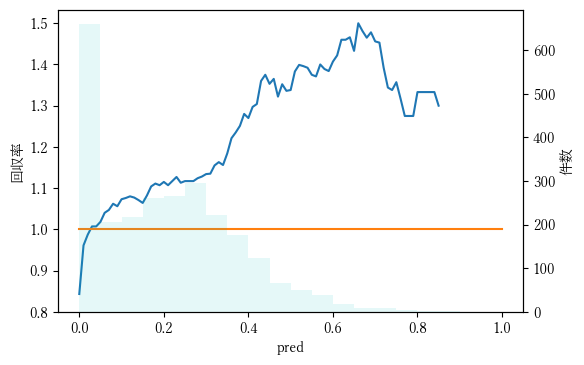

In [327]:
df_ret, max_th = get_return(df_test, 'pred', 1, 0.01, over=True, plot_min=0.8)

In [294]:
df_ret.head()

,対象数,回収率,対象率
0.00,2618.0,0.843,1.000000
0.01,2192.0,0.961,0.837280
0.02,2118.0,0.987,0.809015
0.03,2066.0,1.007,0.789152
0.04,2008.0,1.007,0.766998


In [295]:
df_ret.loc[0.2: 0.5]

,対象数,回収率,対象率
0.20,1273.0,1.115,0.486249
0.21,1231.0,1.107,0.470206
0.22,1165.0,1.117,0.444996
0.23,1118.0,1.127,0.427044
0.24,1059.0,1.113,0.404507
0.25,1008.0,1.117,0.385027
0.26,936.0,1.117,0.357525
0.27,894.0,1.117,0.341482
0.28,836.0,1.124,0.319328
0.29,779.0,1.128,0.297555


In [274]:
df_test['buy'] = 0
df_test.loc[df_test.pred > 0.4, 'buy'] = 1

buy
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: EV, dtype: object

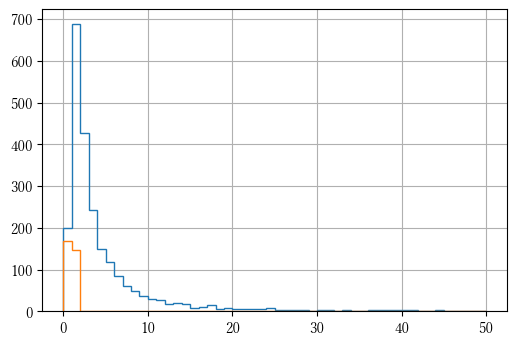

In [275]:
df_test.groupby('buy').EV.hist(bins=50, range=(0, 50), histtype='step')